In [366]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import dlc_practical_prologue as prologue
%matplotlib inline
N=1000
from torch.utils.data import DataLoader, Dataset
import tqdm
from torch.autograd import Variable
count = 0 

In [359]:
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

# case 1: Linear layers: with and without auxillary lose and weight sharing
# case 2: Conv2d with and without auxillary lose and weight sharing
# case 3: with batchnorm and dropouts
# case 4: replace relu with leakyrelu and prrelu 

In [367]:

class CompareNet1(nn.Module):
    def __init__(self):
        super(CompareNet1, self).__init__()
        self.base = nn.Sequential(nn.Linear(196,64),nn.ReLU(),nn.Linear(64,32))
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(32,10) # for auxillary loss removal, remove this
        
    def forward(self, x):
        x_0 = x[:,0,:,:].flatten(1)
        x_1 = x[:,1,:,:].flatten(1)
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        digit_0 = F.relu(self.classifier(x_0))
        digit_1 = F.relu(self.classifier(x_1))
        return sign, digit_0, digit_1

class CompareNet11(nn.Module): #without weight sharing
    def __init__(self):
        super(CompareNet11, self).__init__()
        self.base = nn.Sequential(nn.Linear(392,196),nn.ReLU(),nn.Linear(196,64),nn.ReLU()) 
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(64,100) 
        
    def forward(self, x):
        x = x.view(-1,392)
        x = F.relu(self.base(x))
        print(x.shape)
        sign = F.relu(self.comparator(x))
        num = F.relu(self.classifier(x))
        return sign, num

class CompareNet12(nn.Module): # without auxillary loss
    def __init__(self):
        super(CompareNet12, self).__init__()
        self.base = nn.Sequential(nn.Linear(196,64),nn.ReLU(),nn.Linear(64,32))
        self.comparator = nn.Linear(64,2)
        
    def forward(self, x):
        x_0 = x[:,0,:,:].flatten(1)
        x_1 = x[:,1,:,:].flatten(1)
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        return sign
    

        
class CompareNet2(nn.Module):
    def __init__(self):
        super(CompareNet2, self).__init__()
        self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(32,10)# for auxillary loss removal, remove this
        
        #self.base = nn.Sequential(nn.Linear(392,196),nn.ReLU(),nn.Linear(196,64),nn.ReLU()) # add another base to remove weight sharing
        #self.classifier = nn.Linear(64,100) # to remove weight sharing
    
    def forward(self, x):
        #x = x.flatten(1) # to remove weight sharing
        #x = F.relu(self.base(x))
        x_0 = x[:,:1,:,:]# for conv2d
        x_1 = x[:,1:2,:,:]# for conv2d
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        x_0 = x_0.view(-1,32)
        x_1 = x_1.view(-1,32)
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        digit_0 = F.relu(self.classifier(x_0))
        digit_1 = F.relu(self.classifier(x_1))
        return sign, digit_0, digit_1
    
class CompareNet21(nn.Module): #without weight sharing
    def __init__(self):
        super(CompareNet21, self).__init__()
        self.base = nn.Sequential(nn.Conv2d(2, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.Conv2d(32, 16, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        self.comparator = nn.Linear(64,2)
        self.classifier = nn.Linear(64,100) 
        
    def forward(self, x):
        #x = x.view(-1,392)
        x = F.relu(self.base(x))
        x = x.view(-1,64)
        sign = F.relu(self.comparator(x))
        num = F.relu(self.classifier(x))
        return sign, num

class CompareNet22(nn.Module): # without auxillary loss
    def __init__(self):
        super(CompareNet22, self).__init__()
        self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        self.comparator = nn.Linear(64,2)
        
    def forward(self, x):
        #x_0 = x[:,0,:,:].flatten(1)
        #x_1 = x[:,1,:,:].flatten(1)
        #x_0 = F.relu(self.base(x_0)) 
        #x_1 = F.relu(self.base(x_1))
        x_0 = x[:,:1,:,:]# for conv2d
        x_1 = x[:,1:2,:,:]# for conv2d
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        x_0 = x_0.view(-1,32)
        x_1 = x_1.view(-1,32)
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        return sign

In [368]:
class DigitPairsDataset(Dataset):
    def __init__(self,img_pair,targets, classes):
        super(DigitPairsDataset, self).__init__()
        self.img_pair = img_pair
        self.targets = targets
        self.classes = classes
    
    def __len__(self):
        return self.targets.size()[0]
    
    def __getitem__(self, idx):
        return self.img_pair[idx], self.targets[idx], self.classes[idx]

In [ ]:
#net = CompareNet()
criterion = nn.CrossEntropyLoss()
auxillary = True
linear = False
wt_sharing = True 
conv = True
if linear and auxillary and wt_sharing:
    net = CompareNet1()
    flag = 1
elif linear and auxillary and not wt_sharing:
    net = CompareNet11()
    flag = 11
elif linear and not auxillary and wt_sharing:
    net = CompareNet12()
    flag = 12
elif conv and auxillary and wt_sharing:
    net = CompareNet2()
    flag = 2
elif conv and auxillary and not wt_sharing:
    net = CompareNet21()
    flag = 21
elif conv and not auxillary and wt_sharing:
    net = CompareNet22()
    flag = 22   
    

mu = 1.0
optimizer = optim.Adam(net.parameters(),lr = 0.001)

#classes = 10*classes[:,1]+classes[:,0] # for removing weight sharing

def calc_accuracy(data_loader,model):
    correct_count = 0.0
    for i, data in enumerate(data_loader,0):
        img_pair, target, classes = data
        if auxillary and wt_sharing:
            pred_sign, pred_class0, pred_class1 = net(img_pair)
            loss = criterion(pred_sign,target)+ mu*(criterion(pred_class0, classes[:,0])+ criterion(pred_class1, classes[:,1]))
        elif auxillary and not wt_sharing:
            pred_sign, pred_class = net(img_pair) # to remove weight sharing
            classes = 10*classes[:,1]+classes[:,0]
            loss = criterion(pred_sign,target)+ mu*criterion(pred_class, classes)
        elif not auxillary and wt_sharing:
            pred_sign = net(img_pair)# for removing weight sharing
            loss = criterion(pred_sign,target)
        #pred_sign, pred_class0, pred_class1 = model(img_pair)
        #pred_sign, pred_class = model(img_pair)# for removing weight sharing
        #pred_sign = model(img_pair)# for removing weight sharing
        pred = torch.argmax(pred_sign,-1)
        correct_count += int((target.eq(pred)).sum())
    return correct_count*100.0/N


while count<11:
    epochs = 200
    loss_arr = []
    train_acc_arr = []
    val_acc_arr = []
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    train_dataset = DigitPairsDataset(train_input,train_target,train_classes)
    test_dataset = DigitPairsDataset(test_input,test_target,test_classes)
    train_loader = DataLoader(train_dataset,batch_size=32, shuffle = True, num_workers = 0)
    test_loader = DataLoader(test_dataset,batch_size=32, shuffle = True, num_workers = 0)
    for epoch in tqdm.tqdm(range(epochs)):
        net.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader,0):
            img_pair, target, classes = data

            optimizer.zero_grad()

            if auxillary and wt_sharing:
                pred_sign, pred_class0, pred_class1 = net(img_pair)
                loss = criterion(pred_sign,target)+ mu*(criterion(pred_class0, classes[:,0])+ criterion(pred_class1, classes[:,1]))

            elif auxillary and not wt_sharing:
                pred_sign, pred_class = net(img_pair) 
                classes = 10*classes[:,1]+classes[:,0]
                loss = criterion(pred_sign,target)+ mu*criterion(pred_class, classes)

            elif not auxillary and wt_sharing:
                pred_sign = net(img_pair)
                loss = criterion(pred_sign,target)

            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        net.eval()
        running_loss /= N
        loss_arr.append(running_loss)
        train_acc = calc_accuracy(train_loader,net)
        val_acc = calc_accuracy(test_loader,net)
        train_acc_arr.append(train_acc)
        val_acc_arr.append(val_acc)
        if epoch % 10 == 9:
            print("Epoch : %d  ,   Train Accuracy : %.2f  , Validation Accuracy : %.2f , Training Loss : %.6f" %(epoch, train_acc, val_acc, running_loss))


    plt.plot(range(epochs),loss_arr)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training loss over iterations")
    fileplot1 = "plot_loss_{count}.png".format(count=count)
    plt.savefig(fileplot1)
    plt.show()

    plt.plot(range(epochs),train_acc_arr, label  =" Training accuracy")
    plt.plot(range(epochs), val_acc_arr, label ="Validation accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Training and Validation accuracy during training")
    plt.legend()
    fileplot = "plot_acc_{count}.png".format(count=count)
    plt.savefig(fileplot)
    plt.show()



    fileloss = "loss_{count}.npy".format(count=count)
    np.save(fileloss,loss_arr)
    filetrain = "train_acc_{count}.npy".format(count=count)
    np.save(filetrain,train_acc_arr)
    fileval = "val_acc_{count}.npy".format(count=count)
    np.save(fileval,val_acc_arr)
    count+= 1
    






  0%|                                                                                          | 0/200 [00:00<?, ?it/s]




  0%|▍                                                                                 | 1/200 [00:01<05:31,  1.67s/it]




  1%|▊                                                                                 | 2/200 [00:03<05:29,  1.66s/it]




  2%|█▏                                                                                | 3/200 [00:04<05:19,  1.62s/it]




  2%|█▋                                                                                | 4/200 [00:06<05:13,  1.60s/it]




  2%|██                                                                                | 5/200 [00:07<05:02,  1.55s/it]




  3%|██▍                                                                               | 6/200 [00:09<04:48,  1.49s/it]




  4%|██▊                                                                               | 7/200 [00:10<04:44,  1.47s/it]




  4

Epoch : 9  ,   Train Accuracy : 74.20  , Validation Accuracy : 61.10 , Training Loss : 0.165670







  5%|████                                                                             | 10/200 [00:29<14:12,  4.48s/it]




  6%|████▍                                                                            | 11/200 [00:32<12:31,  3.98s/it]




  6%|████▊                                                                            | 12/200 [00:33<10:08,  3.23s/it]




  6%|█████▎                                                                           | 13/200 [00:35<08:29,  2.73s/it]




  7%|█████▋                                                                           | 14/200 [00:37<07:28,  2.41s/it]




  8%|██████                                                                           | 15/200 [00:38<06:37,  2.15s/it]




  8%|██████▍                                                                          | 16/200 [00:40<05:53,  1.92s/it]




  8%|██████▉                                                                          | 17/200 [00:41<05:14,  1.72s/it]




  9

Epoch : 19  ,   Train Accuracy : 76.90  , Validation Accuracy : 68.00 , Training Loss : 0.125145







 10%|████████                                                                         | 20/200 [01:01<15:01,  5.01s/it]




 10%|████████▌                                                                        | 21/200 [01:03<12:08,  4.07s/it]




 11%|████████▉                                                                        | 22/200 [01:05<09:51,  3.32s/it]




 12%|█████████▎                                                                       | 23/200 [01:06<08:11,  2.78s/it]




 12%|█████████▋                                                                       | 24/200 [01:08<07:00,  2.39s/it]




 12%|██████████▏                                                                      | 25/200 [01:09<06:11,  2.12s/it]




 13%|██████████▌                                                                      | 26/200 [01:11<05:34,  1.92s/it]




 14%|██████████▉                                                                      | 27/200 [01:12<05:08,  1.78s/it]




 14

Epoch : 29  ,   Train Accuracy : 81.00  , Validation Accuracy : 69.30 , Training Loss : 0.100346







 15%|████████████▏                                                                    | 30/200 [01:30<13:44,  4.85s/it]




 16%|████████████▌                                                                    | 31/200 [01:35<13:27,  4.78s/it]




 16%|████████████▉                                                                    | 32/200 [01:37<11:03,  3.95s/it]




 16%|█████████████▎                                                                   | 33/200 [01:38<09:05,  3.27s/it]




 17%|█████████████▊                                                                   | 34/200 [01:40<07:53,  2.85s/it]




 18%|██████████████▏                                                                  | 35/200 [01:42<07:04,  2.57s/it]




 18%|██████████████▌                                                                  | 36/200 [01:44<06:14,  2.28s/it]




 18%|██████████████▉                                                                  | 37/200 [01:45<05:30,  2.03s/it]




 19

Epoch : 39  ,   Train Accuracy : 83.50  , Validation Accuracy : 72.80 , Training Loss : 0.091425







 20%|████████████████▏                                                                | 40/200 [02:18<22:34,  8.47s/it]




 20%|████████████████▌                                                                | 41/200 [02:21<17:43,  6.69s/it]

In [ ]:
plt.plot(range(epochs),loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss over iterations")
fileplot1 = "plot_loss_{count}.png".format(count=count)
plt.savefig(fileplot1)
plt.show()

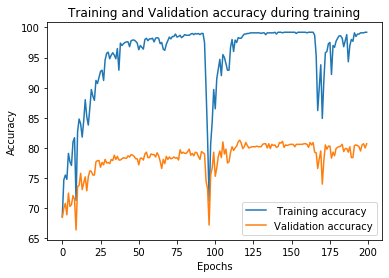

In [351]:
plt.plot(range(epochs),train_acc_arr, label  =" Training accuracy")
plt.plot(range(epochs), val_acc_arr, label ="Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Training and Validation accuracy during training")
plt.legend()
fileplot = "plot_acc_{count}.png".format(count=count)
plt.savefig(fileplot)
plt.show()
count+= 1

In [356]:
np.save('markers.npy', train_acc_arr)

In [354]:
print(train_acc_arr)


[68.6, 74.7, 75.5, 74.8, 79.1, 77.7, 77.1, 81.0, 81.7, 71.3, 82.7, 84.8, 84.0, 81.8, 84.5, 88.0, 85.2, 83.8, 86.6, 89.7, 88.6, 87.9, 91.2, 90.7, 91.7, 92.7, 92.9, 91.2, 94.6, 95.7, 95.9, 94.8, 95.4, 95.8, 95.4, 94.8, 96.5, 92.9, 97.4, 97.0, 97.3, 97.5, 97.6, 97.6, 96.8, 97.8, 97.9, 97.9, 97.7, 97.4, 96.3, 97.0, 96.7, 96.4, 98.0, 98.2, 97.8, 98.1, 98.1, 98.2, 97.6, 98.2, 98.3, 98.2, 97.3, 97.5, 96.4, 96.2, 97.2, 97.8, 98.4, 98.1, 98.5, 98.5, 98.9, 98.4, 98.5, 98.7, 98.3, 98.5, 98.8, 98.7, 98.7, 98.7, 98.9, 99.0, 98.8, 99.0, 98.9, 99.0, 98.8, 99.0, 99.0, 97.5, 89.8, 81.5, 71.2, 80.6, 84.3, 89.7, 86.5, 91.5, 93.1, 94.7, 92.0, 95.5, 95.0, 94.0, 92.9, 92.9, 96.7, 98.0, 96.0, 97.9, 97.5, 98.3, 98.2, 98.2, 98.6, 98.9, 98.9, 99.0, 99.0, 99.1, 99.1, 99.1, 99.1, 99.1, 99.1, 99.1, 99.0, 99.1, 99.1, 98.8, 99.1, 99.1, 99.1, 99.1, 99.1, 99.2, 98.9, 99.2, 99.2, 99.2, 99.1, 99.2, 99.2, 99.2, 99.2, 99.2, 99.2, 99.2, 99.2, 99.0, 99.2, 99.2, 99.2, 99.2, 99.2, 99.2, 99.1, 99.2, 99.2, 99.2, 99.2, 98.7, 95.

In [357]:
markers = np.load("markers.npy")
print(markers)

[68.6 74.7 75.5 74.8 79.1 77.7 77.1 81.  81.7 71.3 82.7 84.8 84.  81.8
 84.5 88.  85.2 83.8 86.6 89.7 88.6 87.9 91.2 90.7 91.7 92.7 92.9 91.2
 94.6 95.7 95.9 94.8 95.4 95.8 95.4 94.8 96.5 92.9 97.4 97.  97.3 97.5
 97.6 97.6 96.8 97.8 97.9 97.9 97.7 97.4 96.3 97.  96.7 96.4 98.  98.2
 97.8 98.1 98.1 98.2 97.6 98.2 98.3 98.2 97.3 97.5 96.4 96.2 97.2 97.8
 98.4 98.1 98.5 98.5 98.9 98.4 98.5 98.7 98.3 98.5 98.8 98.7 98.7 98.7
 98.9 99.  98.8 99.  98.9 99.  98.8 99.  99.  97.5 89.8 81.5 71.2 80.6
 84.3 89.7 86.5 91.5 93.1 94.7 92.  95.5 95.  94.  92.9 92.9 96.7 98.
 96.  97.9 97.5 98.3 98.2 98.2 98.6 98.9 98.9 99.  99.  99.1 99.1 99.1
 99.1 99.1 99.1 99.1 99.  99.1 99.1 98.8 99.1 99.1 99.1 99.1 99.1 99.2
 98.9 99.2 99.2 99.2 99.1 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.
 99.2 99.2 99.2 99.2 99.2 99.2 99.1 99.2 99.2 99.2 99.2 98.7 95.3 86.2
 89.9 93.8 84.9 91.1 95.8 96.  97.3 97.5 92.2 97.  96.7 97.7 98.2 98.6
 98.6 98.2 96.8 97.8 98.8 94.3 97.  98.  97.7 99.1 98.5 98.9 98.9 99.1
 99.1 99